# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
from tqdm.notebook import tqdm

from khan_helpers import Experiment, Participant
from khan_helpers.constants import FIG_DIR, RAW_DIR
from khan_helpers.functions import (
    bootstrap_ci_plot, 
    multicol_display, 
    reconstruct_trace, 
    set_figure_style,
    show_source
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Inspect some things defined in `khan_helpers`

In [2]:
show_source(Participant)

In [3]:
show_source(reconstruct_trace)

In [4]:
show_source(bootstrap_ci_plot)

# Load data

In [5]:
exp = Experiment()
raw_data = pd.read_csv(RAW_DIR.joinpath('psiturk-data-raw.tsv'), 
                       sep='\t', 
                       index_col='Unnamed: 0')
raw_data.head()

,uniqueid,assignmentid,workerid,hitid,ipaddress,browser,platform,language,cond,counterbalance,codeversion,beginhit,beginexp,endhit,bonus,status,mode,datastring
0,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB5FF69,A32JOXA6ZU7Q0Y,33K3E8REWX1EFBLACVAPTDY1FXBX8T,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-26 17:47:30,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
1,debuga32joxa6zu7q0y:debug304sm51wa5ar8cvcbztd9...,304SM51WA5AR8CVCBZTD9R2QEXQSBY,A32JOXA6ZU7Q0Y,391FPZIE4DSFRIS8AUT8MJSWOZUHUC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 18:43:33,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
2,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB6M6F9,A32JOXA6ZU7Q0Y,31MBOZ6PAPXLRKUYFON6K5ZXYGXCL5,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 19:29:40,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
3,debugdebugwzop7d:debugdebug4j19zm,3OE22WJIGKUURVP5JML3JHFDLUOUQ4,A32JOXA6ZU7Q0Y,3P520RYKCIC3BP8D9SSZXMP6JRR5U9,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-01 19:34:15,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
4,debuga32joxa6zu7q0y:debug3dzqrbdbsnlm5hrzw6e7r...,3DZQRBDBSNLM5HRZW6E7R84EQ50S3U,A32JOXA6ZU7Q0Y,36FFXPMSTAUKED8BE8HZND076EHHOC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-03 17:54:55,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."


# Create Participant objects

In [6]:
participants = []
for ix, row in tqdm(raw_data.iterrows(), total=raw_data.shape[0], leave=False):
    p = Participant.from_psiturk(row, subid=f'P{ix + 1}')
    participants.append(p)
    
# Participant object to store across-participant avgerages
avg_participant = Participant('avg')

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
# 6 sample participants' data for first 5 questions of quiz block 1
multicol_display(*(p.head() for p in participants[:6]), 
                 ncols=3, 
                 table_css={'border-collapse': 'separate', 
                            'border-spacing': '0 1em'},
                 row_css={'background-color': 'white'})

,qID,accuracy,response,quiz,lecture
0,13,1,A,0,1
1,21,0,B,0,2
2,12,0,D,0,1
3,16,1,A,0,2
4,28,1,A,0,2
,qID,accuracy,response,quiz,lecture
0,24,0,B,0,2
1,25,0,B,0,2
2,2,0,D,0,1
3,30,0,B,0,2


# Reconstruct knowledge for each set of quiz questions, for each lecture

In [8]:
traces = {}
for lec_name, lec_traj in (('forces', exp.forces_traj), ('bos', exp.bos_traj)):
    trace_arr = np.empty((3, len(participants), lec_traj.shape[0]), 
                         dtype=np.float64)
    for quiz in range(3):
        store_key = f'{lec_name}_quiz{quiz}'
        for i, p in enumerate(participants):
            # get participant's data for questions about the given 
            # lecture, from the given quiz
            lec_quiz_data = p.get_data(lecture=lec_name, quiz=quiz)
            # get topic vectors for those questions...
            qs_vecs = exp.question_vectors[lec_quiz_data['qID'] - 1]
            # and participant's performance on them
            acc = lec_quiz_data['accuracy']
            
            trace = reconstruct_trace(lecture=lec_traj, 
                                      questions=qs_vecs, 
                                      accuracy=acc)
            trace_arr[quiz, i] = trace
            p.store_trace(trace=trace, store_key=store_key)
            
        # store average trace in avg participant object
        avg_participant.store_trace(trace=trace_arr[quiz].mean(axis=0), 
                                    store_key=store_key)
    traces[lec_name] = trace_arr

# Save Participant objects with reconstructed traces

In [9]:
# for p in participants:
#     p.save()
    
# avg_participant.save()

# Plot model-derived content mastery

In [10]:
ff_traces = np.swapaxes(traces['forces'], 1, 2)
bos_traces = np.swapaxes(traces['bos'], 1, 2)

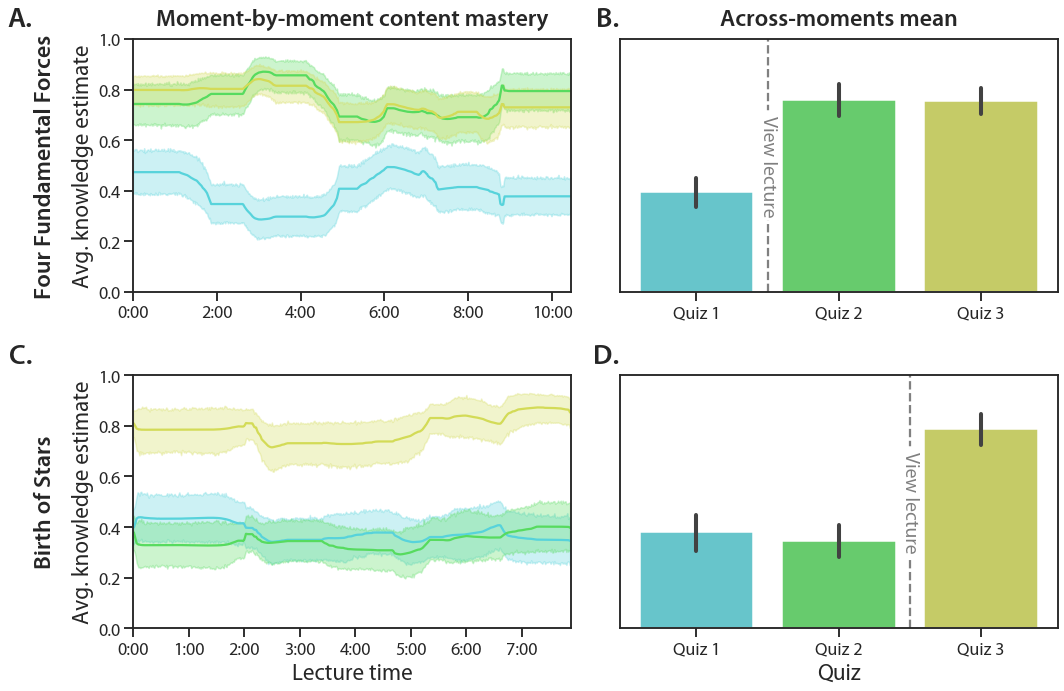

In [11]:
with (
    sns.plotting_context('talk', font_scale=1.1), 
    sns.axes_style('ticks'), 
    sns.color_palette(np.array(sns.hls_palette())[[3, 2, 1]])
):
    set_figure_style()
    fig, axarr = plt.subplots(2, 2, sharey=True)
    fig.set_size_inches(15, 10)
    ((a, b),
     (c, d)) = axarr

    # ==================== Four Fundamental Forces =====================
    # moment-by-moment knowledge estimate
    for quiz in range(3):
        bootstrap_ci_plot(ff_traces[quiz], 
                          color=sns.utils.get_color_cycle()[quiz], 
                          ax=a)
    a.set_xlim(0, ff_traces.shape[1])
    a.set_ylim(0, 1)
    a.set_ylabel('Avg. knowledge estimate', fontsize=23)
    a.set_xticks(range(0, ff_traces.shape[1], 120), 
                 [f'{i//60}:00' for i in range(0, ff_traces.shape[1], 120)])
    a.set_title('Moment-by-moment content mastery', 
                y=1.03, 
                fontsize=24, 
                fontweight='semibold')
    a.annotate('Four Fundamental Forces', 
               xy=(-.75, .5), 
               xycoords=a.yaxis.label, 
               size=24, 
               fontweight='semibold',
               rotation=90, 
               ha='right', 
               va='center')

    # across-moments mean
    sns.barplot(data=ff_traces.mean(axis=1).T, ax=b)
    b.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
    b.set_ylim(0, 1)
    b.tick_params(axis='y', length=0)
    b.set_title('Across-moments mean', 
                y=1.03, 
                fontsize=24, 
                fontweight='semibold')
    vline = b.vlines(x=.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
    b.text(x=0.5, 
           y=0.5, 
           s='View lecture', 
           ha='center', 
           va='center', 
           rotation=270, 
           color='gray', 
           backgroundcolor='white')
    
    
    # ========================= Birth of Stars =========================
    # moment-by-moment knowledge estimate
    for quiz in range(3):
        bootstrap_ci_plot(bos_traces[quiz], 
                          color=sns.utils.get_color_cycle()[quiz], 
                          ax=c)
    c.set_xlim(0, bos_traces.shape[1])
    c.set_ylim(0, 1)
    c.set_xlabel('Lecture time', fontsize=23)
    c.set_ylabel('Avg. knowledge estimate', fontsize=23)
    c.set_xticks(range(0, bos_traces.shape[1], 60), 
                 [f'{i//60}:00' for i in range(0, bos_traces.shape[1], 60)])
    c.annotate('Birth of Stars', 
               xy=(-.75, .5), 
               xycoords=c.yaxis.label, 
               size=24, 
               fontweight='semibold',
               rotation=90, 
               ha='right', 
               va='center')

    # across-moments mean
    sns.barplot(data=bos_traces.mean(axis=1).T, ax=d)
    d.set_ylim(0, 1)
    d.set_xlabel('Quiz', fontsize=23)
    d.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
    d.tick_params(axis='y', length=0)
    d.vlines(x=1.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
    d.text(x=1.5, 
           y=0.5, 
           s='View lecture', 
           ha='center', 
           va='center', 
           rotation=270, 
           color='gray', 
           backgroundcolor='white')

    # Panel labels
    labels = 'ABCD'
    for i, ax in enumerate((a, b, c, d)):
        if ax in (a, c):
            x_coord = -0.23
        else:
            x_coord = 0
        
        ax.text(x_coord, 
                1.05, 
                f'{labels[i]}.', 
                fontsize='x-large', 
                fontweight='semibold', 
                horizontalalignment='right', 
                transform=ax.transAxes)

    plt.tight_layout()
#     plt.savefig(FIG_DIR.joinpath('content-mastery.pdf'), bbox_inches='tight')
    plt.show()

# Run stats on knowledge estimates between quizzes

In [12]:
# across-timepoints avg. knowledge estimate for each participant
ff_knowledge = ff_traces.mean(axis=1)
bos_knowledge = bos_traces.mean(axis=1)

df = len(participants) - 1

print('Four Fundamental Forces:')
for i in range(3):
    for j in range(3):
        if i > j:
            print(f'\tQuiz {i + 1} vs Quiz {j + 1}:')
            t, p = ttest_rel(ff_knowledge[i], ff_knowledge[j])
            print(f'\t\tt({df}) = {t}, p = {p}')

print('Birth of Stars:')
for i in range(3):
    for j in range(3):
        if i > j:
            print(f'\tQuiz {i + 1} vs Quiz {j + 1}:')
            t, p = ttest_rel(bos_knowledge[i], bos_knowledge[j])
            print(f'\t\tt({df}) = {t}, p = {p}')

Four Fundamental Forces:
	Quiz 2 vs Quiz 1:
		t(49) = 8.764252677173305, p = 1.3276906400221112e-11
	Quiz 3 vs Quiz 1:
		t(49) = 10.518990567095043, p = 3.653936485128574e-14
	Quiz 3 vs Quiz 2:
		t(49) = -0.16003782947458003, p = 0.8735091916959669
Birth of Stars:
	Quiz 2 vs Quiz 1:
		t(49) = -1.0132659356079388, p = 0.31591056940687867
	Quiz 3 vs Quiz 1:
		t(49) = 8.96884711526648, p = 6.561229007206096e-12
	Quiz 3 vs Quiz 2:
		t(49) = 10.56071558770364, p = 3.1901003652277564e-14
